In [1]:
import copy
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data

In [5]:
import trove

# Load Data

In [6]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm12i_md',
)

In [7]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [8]:
h_param = .702

In [9]:
mvir = verdict.Dict({})
for key in tqdm.tqdm( data['n_tracked'].keys() ):
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600] )[0]/h_param

100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


# Extract Quantities

In [10]:
delta_thin_disk = (
    data['circularity']['thin_disk_fractions'].inner_item( 4 ) - 
    data['circularity']['thin_disk_fractions'].inner_item( 2 )
)

In [11]:
values = {
    'delta_thin_disk': delta_thin_disk,
    'median_R1e5K': data['R1e5K']['median'],
    'thin_disk_frac': data['thin_disk_fraction'],
    'mvir': mvir,
}

# Plot

In [12]:
labels = {
    'delta_thin_disk': r'$\Delta f_{\rm thin}$',
    'median_R1e5K': r'$R_{T=10^5\, {\rm K}}$ (kpc)',
    'thin_disk_frac': r'$f_{\rm thin}(\star,z=0)$',
    'mvir': r'$M_{\rm vir}(z=0)$  $(M_\odot)$',
}

In [13]:
logscale = [ 'mvir', ]

In [14]:
markers = {
    'md': 'o',
    'cr': '^',
    'mhdcv': 'P',
    '': 's',
}

In [15]:
marker_labels = {
    'md': 'Hydro+',
    'cr': 'CR+',
    'mhdcv': 'MHD+',
    '': 'no metal diffusion',
}

In [16]:
value_keys = list( values.keys() )

In [17]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

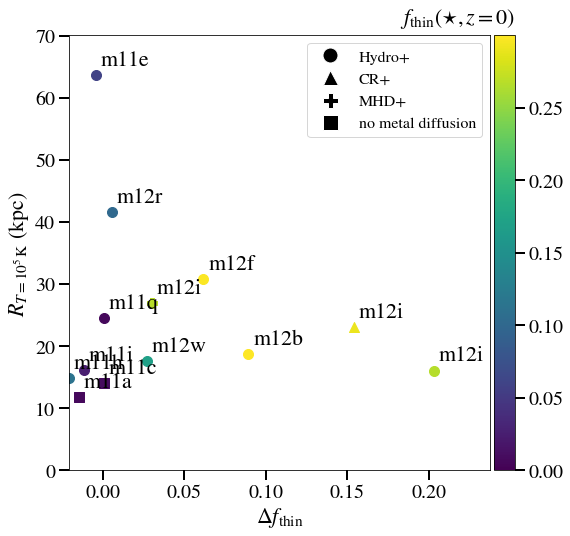

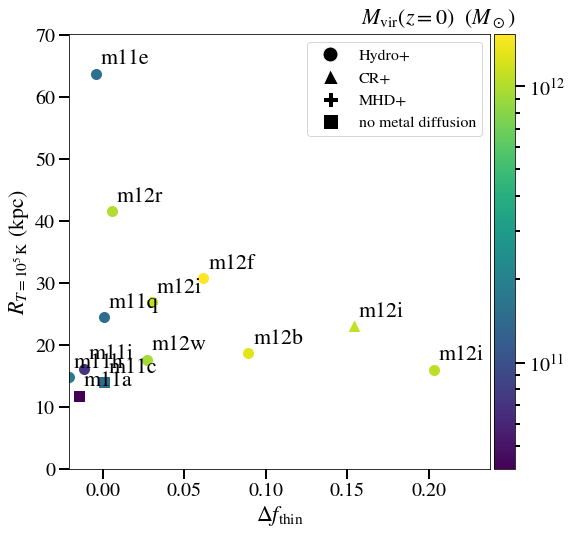

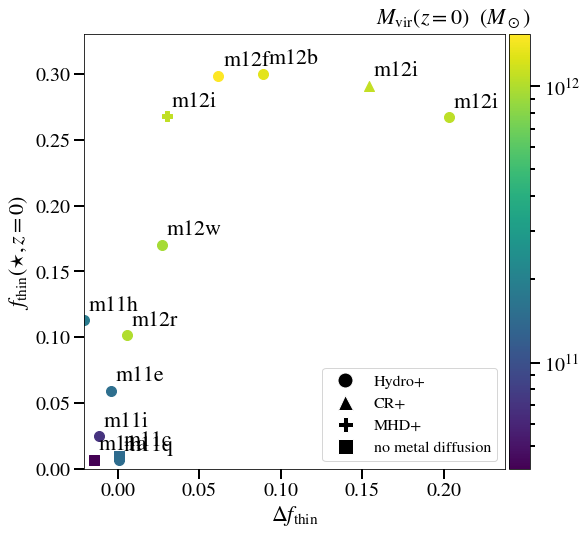

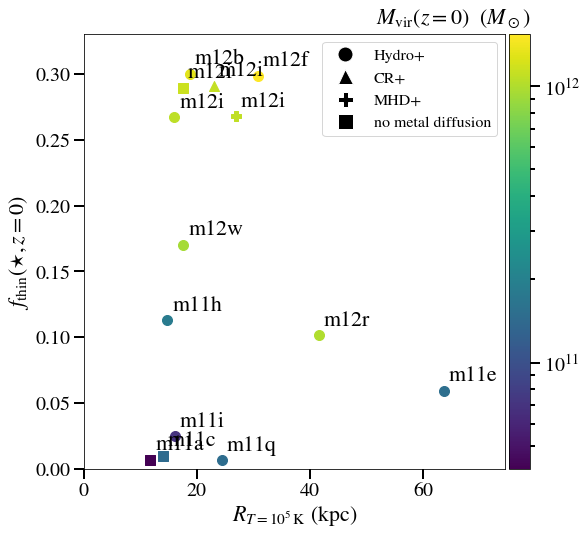

In [18]:
for i, (x_key, y_key, z_key) in enumerate( itertools.combinations( value_keys, 3 ) ):
    
    xs = values[x_key]
    ys = values[y_key]
    zs = values[z_key]
    
    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale
    
    def get_min( vs, is_log ):
        min_v = np.nanmin( vs.array() )
        if not is_log:
            return min( 0, min_v )
        else:
            return min_v
        
    x_lims = get_min( xs, x_log), np.nanmax( xs.array() )*1.17
    y_lims = get_min( ys, y_log), np.nanmax( ys.array() )*1.1
    z_lims = get_min( zs, z_log), np.nanmax( zs.array() )

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    for key, x in xs.items():
        
        if np.isnan( x ):
            continue
        
        y = ys[key]
        z = zs[key]
        
        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
            
        s = ax.scatter(
            x,
            y,
            s = 100,
            color = c,
            marker = markers[physics]
        )

        ax.annotate(
            s = sim_name,
            xy = ( x, y ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
        
    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )
    
    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )
    
    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )
    
    # Legend
    legend_elements = [
        Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
        for _ in markers.keys()
    ]
    ax.legend(
        handles=legend_elements,
        prop = {'size': 16 },
    )
    
    # Colorbar
    if not z_log:
        norm_class = mpl.colors.Normalize
    else:
        norm_class = mpl.colors.LogNorm
    norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
    divider = make_axes_locatable( ax )
    cax = divider.append_axes( "right", pad=0.05, size='5%' )
    cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )
    
    # Colorbar label
    cax.annotate(
        s = labels[z_key],
        xy = (1,1),
        xytext = ( 0, 5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 22,
        ha = 'right',
        va = 'bottom',
    )

* ~~Convert R1e5K to fraction of virial radius, galaxy radius~~
* ~~Do thin disk fraction for stars born within the last Gyr~~
* ~~Do PDF cos(theta) = 0~~
* ~~Try spherical harmonic moments, specifically Ylm = Y2,0~~
* Do both before/after and just after.
* ~~16th to 84th percentile of $\cos\theta$, call it $\sigma_{\cos\theta}$~~
* ~~Std of $\cos\theta$~~